
# Predicting Bankruptcy in the mining industry with Altman's Z-score and the Calcbench API

Edward Altman's Z-score is a formula for predicting corporate bankruptcy.  Below we plot the change in industry aggregate Z-scores for mining companies.  A Z-score above 2.99 is considered "safe", between 1.81 and 2.99 is a "gray" zone, below 1.81 is the "distress" zone.  The troubles in the coal and metal mining industry are clearly illustrated.

[Altman's Z-score @ Wikipedia](https://en.wikipedia.org/wiki/Altman_Z-score)

To replicate the below [sign up for a Calcbench account](https://www.calcbench.com/join), install the Calcbench Python API client from [here](https://github.com/calcbench/python_api_client) and download this note book from [github](https://github.com/calcbench/notebooks/blob/master/z-score.ipynb).

In [1]:
import calcbench as cb
import pandas as pd
pd.options.display.max_rows = 1000
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
z_score_metrics = ['CurrentAssets',
                   'CurrentLiabilities', 
                   'Assets', 
                   'RetainedEarnings', 
                   'EBIT', 
                   'MarketCapAtEndOfPeriod',
                   'Liabilities',
                   'Revenue']

In [3]:
SIC_codes = {
    "Oil And Gas Extraction" : 1300,
    "Metal Mining" : 1000,
    "Coal Mining" : 1200,
    "Mining Nonmetallic Minerals" : 1400,
}

In [8]:
def peer_group_z_score(peer_group):
    peer_group = peer_group[(peer_group.ticker != 'GMC') & (peer_group.ticker != 'PPI')] #GMC's marketvalue is off
    z_score_data = cb.normalized_dataframe(company_identifiers=list(peer_group.ticker), 
                                           metrics=z_score_metrics, 
                                           start_year=2008, start_period=0, 
                                           end_year=2017, end_period=0)
    aggregate_data = z_score_data.sum(level=[0], axis=1)
    return compute_z_score(aggregate_data), z_score_data

In [9]:
def compute_z_score(inputs):
    #from https://github.com/calcbench/notebooks/blob/master/z-score.ipynb
    working_capital = inputs['CurrentAssets'] - inputs['CurrentLiabilities']
    

    z_score = (1.2 * (working_capital / inputs['Assets']) + 
              1.4 * (inputs['RetainedEarnings'] / inputs['Assets']) +
              3.3 * (inputs['EBIT'] / inputs['Assets']) +
              0.6 * (inputs['MarketCapAtEndOfPeriod'] / inputs['Liabilities']) +
              .99 * (inputs['Revenue'] / inputs['Assets']))
    
    return z_score

In [10]:
peer_groups = [(industry, cb.companies(SIC_codes=[SIC_code])) for industry, SIC_code in SIC_codes.items()]
sp500 = cb.companies(index="SP500")
sp500_no_financials = sp500[sp500.sic_code & ((sp500.sic_code < 6000) | (sp500.sic_code >= 7000))] # There is a different z-score formulas for financials.
peer_groups.append(("SP500 (no financials)", sp500_no_financials))
industry_z_scores = [(industry, peer_group_z_score(peer_group)[0]) for industry, peer_group in peer_groups]
z_scores = pd.DataFrame.from_items(industry_z_scores)

c:\users\andrew kittredge\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


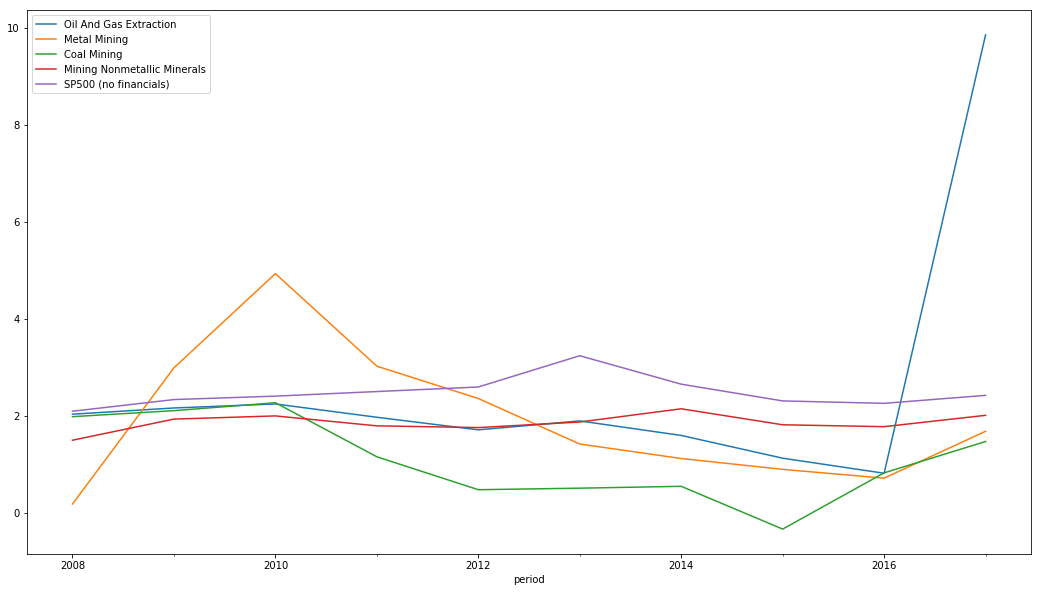

In [11]:
z_scores.plot(figsize=(18, 10))

In [69]:
z_score, data = peer_group_z_score(peer_groups[0][1])

In [78]:
compute_z_score(data.swaplevel(0, 1, 1).ACI)

period
2008         NaN
2009    1.496238
2010    2.372645
2011    0.872310
2012    0.393262
2013    0.211907
2014    0.247459
2015         NaN
Freq: A-DEC, dtype: float64